This notebook sets up and runs a series of analyses that are dispatched either locally (using the `subprocess` Python module) or remotely onto a *Slurm*+*singularity* enabled computer cluster, to parallelize the computation.

The analysis consists in processing regions of interest from multiple (here two) SPT data files.
Each region of interest is spatially segmented, and then DV inference is performed in the resulting space bins.

Such computation can be easily parallelized for the various regions of interest.

# Approach

In this notebook, we will perform all these operations in a single step that will be distributed down to the region-of-interest level (or granularity).

[Another notebook](RWAnalyzer%20multi-stage%20pipeline.ipynb) demonstrates the pipeline capability dividing the segmentation and inference steps as distinct pipeline stages that are distributed down to distinct granularities.
As discussed in this other notebook, the multi-stage approach is more complex and raises a bunch of issues to be careful with.

As a consequence, we advise the user to favor the present notebook as a model to design custom "pipelines", in the cases the *'roi'* granularity is suitable for all the analysis steps that s·he wishes to parallelize.

# Launching the pipeline

If the notebook is run at least until the `a.run()` cell, the corresponding *.ipynb* file is exported and run in other processes or worker nodes.
This implies that the notebook should be saved (*Save and Checkpoint*) before you *Restart & Run All*, if it has been recently modified.

The first notebook cells show how to set up the pipeline. The pipeline is actually launched at the `a.run()` cell of code, where `a` is the main `RWAnalyzer` object.

The notebook lines after the first call to the `run` method are never dispatched. Any second or third call to `run` would run the same initial part of the notebook. Calling `run` multiple times is consequently strongly discouraged.

# A simple *tessellate-and-infer* pipeline to resolve diffusivity and effective potential in space

The main difficulty in dispatching computations on remote hosts lies in locating the data files.
An approach that has been favored in the use cases developed as of version `0.5` consists of making all the paths absolute.

To match the local data files with a copy at a different location on the remote host, environment variables may be helpful.

Notably, the '\~' placeholder for the home/user directory is properly interpreted. If the local and remote data locations can be reached through a same path relative to the home directory, using this relative path made absolute with the '\~' placeholder should work fine without any explicit mapping.

As detailed by the [Locating the data](#locating-the-data) section, data locations that differ on the local and remote hosts can be explicitly mapped on one another, with helpers for specific locations such as the *scratch* personal space.

Let us get the parent directory path of this notebook, assuming the TRamWAy source in locally available somewhere in the home directory:

In [1]:
import os
from tramway.analyzer.spt_data import glob

wd = '~/' + os.path.relpath(os.getcwd(), os.path.expanduser('~')).replace('\\', '/')
wd

'~/github/TRamWAy/notebooks'

We set up an `RWAnalyzer` object with SPT data files, the corresponding files for regions of interest,
the segmentation to be applied to each ROI, and the inference procedure to be applied to each microdomain.

In [2]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_files(f'{wd}/data-examples/*.rpt.txt')
a.spt_data.localization_precision = 0.03

a.roi.from_ascii_files(suffix='roi') # => *.rpt-roi.txt

a.tesseller                       = tessellers.GWR
a.tesseller.resolution            = 0.05

a.mapper.from_plugin('stochastic.dv')
a.mapper.diffusivity_prior        = 20
a.mapper.potential_prior          = 1
a.mapper.max_runtime              = 100 # in seconds; 100 seconds is much too short for a proper DV estimation, but convenient for a quick example
a.mapper.verbose                  = False
a.mapper.worker_count             = None if os.name == 'nt' else 4 # Windows OS is not fully supported yet

Let us make sure the paths are alright. The following two notebook cells are optional.

Of note, this notebook assumes the [introduction notebook](RWAnalyzer%20tour.ipynb) ran before, so that the input data (both SPT and ROI files) are available.

In [3]:
a.spt_data.filepaths

['/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt',
 '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt']

In [4]:
[ f.roi.filepath for f in a.spt_data ]

['/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt-roi.txt',
 '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt-roi.txt']

Before defining the main pipeline stage, we can ensure that none of *.rwa* files to be generated exists, both on the submit and worker sides, introducing the following `fresh_start` stage:

In [5]:
def fresh_start(self):
    """
    Deletes the *.rwa* files associated with the SPT data files, if any.
    """
    for f in self.spt_data:
        output_rwa_file = os.path.splitext(f.source)[0] + '.rwa'
        try:
            os.unlink(output_rwa_file)
        except FileNotFoundError:
            pass

a.pipeline.append_stage(fresh_start)

In this example, the `fresh_start` stage makes no obvious difference, since `tessellate_and_infer` is supposed to process all the regions of interest and overwrite all the *.rwa* files.

However, if the output *.rwa* files already exist, the pipeline loads and updates these files with the new analysis artefacts.

In addition, in the general case, if the `tessellate_and_infer` stage totally fails and the pipeline on the submit side does not get aware of the failure, the user may not realize the expected files have not been updated.

In [6]:
a.pipeline.append_stage(stages.tessellate_and_infer())

The declarative approach to setting a pipeline grants control over how to run the pipeline.

This allows running arrays of inferences equally on a local computer or across a computer cluster. The RWAnalyzer pipeline capability has been focused in particular on Slurm- and singularity-enabled clusters, communicating with these clusters through an SSH connection.

At *Institut Pasteur* in Paris, France, the main computer cluster was baptised *Maestro*.
The `environments` module exported by the `tramway.analyzer` package features a `Maestro` predefined environment that can be used to set the `env` attribute of an `RWAnalyzer` object.

This environment object takes the local username to connect to the *Maestro* submit node. This can be overriden with the `env.username` attribute.

However, the Maestro cluster is accessible only over *Institut Pasteur*'s VPN or from the campus.

To make this notebook run in more different circumstances, we will use the `LocalHost` environment instead.
This environment operates in a similar fashion, but on the local computer, and does not involve any remote resource.

It actually offers a convenient way to test a pipeline before running the same pipeline on a computer cluster.

In [7]:
#a.env                             = environments.Maestro # works only over Institut Pasteur's VPN or on campus
a.env                             = environments.LocalHost # replacement so that the demo can work anywhere
a.env.worker_count                = 5 # beware this multiplies with a.mapper.worker_count

a.env.script                      = 'RWAnalyzer simple pipeline.ipynb'

Of note, the `LocalHost` environment does not need absolute paths to the data files.

If someday you may export this notebook as a regular Python script, you should consider using the `__file__` variable, as demonstrated in the following code cell, as a replacement for the last line above. Otherwise, you can safely delete the following cell:

In [8]:
try:
    a.env.script                  = __file__
except NameError:
    # in an IPython notebook, `__file__` is not defined and there is no standard way to get the notebook's name
    a.env.script                  = 'RWAnalyzer simple pipeline.ipynb'

The following cell is also optional. The default logging (or verbosity) level is `INFO`.

In [9]:
import logging

a.logger.setLevel(logging.DEBUG)

The `run` method launches the pipeline.
The workload is concentrated in the following code cell:

In [10]:
a.run()

working directory: /tmp/tmp1lrwsams
setup complete
running: jupyter nbconvert --to python "/home/flaurent/github/TRamWAy/notebooks/RWAnalyzer simple pipeline.ipynb" --stdout
initial dispatch done

jobs ready
submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=0
jobs submitted
setup complete
stage 0 ready
stage 0 done
job 0 done

jobs complete
skipping empty file /tmp/tmp1lrwsams/tmpxdikefck.rwa
skipping empty file /tmp/tmp1lrwsams/tmp2d9ko8p8.rwa

jobs ready
submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=0
submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=1
submi

setup complete
stage 1 ready
tessellating roi: 'roi012' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi012' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 12 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=17
setup complete
stage 1 ready
tessellating roi: 'roi013' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi013' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 13 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --sour

setup complete
stage 1 ready
tessellating roi: 'roi027' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi027' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 27 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=32
setup complete
stage 1 ready
tessellating roi: 'roi028' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi028' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
sparse_grad failed at all the columns

sparse_grad failed at all the columns

sparse_grad failed at all the columns

sparse_grad failed at all the c

job 38 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=43
setup complete
stage 1 ready
tessellating roi: 'roi039' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi039' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
sparse_grad failed at all the columns

sparse_grad failed at all the columns

sparse_grad failed at all the columns

sparse_grad failed at all the columns

stage 1 done
error: Process None-3 died with error (most recent call last):
  File "/home/flaurent/github/TRamWAy/tramway/core/parallel/__init__.py", line 211, in run
    self.target(*self.args, **self.kwargs)
  File "/home/flaurent/github/TRamWAy/tramway/inference/optimization.py", line 1413, in ta

job 46 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=51
setup complete
stage 1 ready
tessellating roi: 'roi047' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi047' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 47 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=52
setup complete
stage 1 ready
tessellating roi: 'roi048' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi048' (in sou

job 61 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=66
setup complete
stage 1 ready
tessellating roi: 'roi062' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi062' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 62 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=67
setup complete
stage 1 ready
tessellating roi: 'roi063' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi063' (in sou

setup complete
stage 1 ready
tessellating roi: 'roi073' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi073' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 73 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt" --region-index=78
setup complete
stage 1 ready
tessellating roi: 'roi074' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
infering roi: 'roi074' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-02-15ms.rpt.txt')...
stage 1 done
job 74 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --sour

setup complete
stage 1 ready
tessellating roi: 'roi005' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt')...
infering roi: 'roi005' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt')...
stage 1 done
job 88 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --source="/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt" --region-index=10
setup complete
stage 1 ready
tessellating roi: 'roi006' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt')...
infering roi: 'roi006' (in source '/home/flaurent/github/TRamWAy/notebooks/data-examples/Manip01-01-Beta400AA-01-15ms.rpt.txt')...
stage 1 done
job 89 done

submitting: /usr/bin/python3 /tmp/tmp1lrwsams/tmpp6int7rs.py --working-directory="/tmp/tmp1lrwsams" --stage-index=1 --sour

job 104 done

jobs complete
reading file: /tmp/tmp1lrwsams/tmpfmu6zsb4.rwa
reading file: /tmp/tmp1lrwsams/tmpljte3ke4.rwa
reading file: /tmp/tmp1lrwsams/tmp9ll6zkvd.rwa
skipping empty file /tmp/tmp1lrwsams/tmpjmth49k_.rwa
reading file: /tmp/tmp1lrwsams/tmpwu1gsag7.rwa
reading file: /tmp/tmp1lrwsams/tmpa4qrhxr5.rwa
skipping empty file /tmp/tmp1lrwsams/tmp3jpfl6ok.rwa
skipping empty file /tmp/tmp1lrwsams/tmpc25wayc9.rwa
skipping empty file /tmp/tmp1lrwsams/tmpgfui9qsd.rwa
skipping empty file /tmp/tmp1lrwsams/tmpvl0g83t2.rwa
reading file: /tmp/tmp1lrwsams/tmpqhq2vnu7.rwa
skipping empty file /tmp/tmp1lrwsams/tmp_cg4haqi.rwa
reading file: /tmp/tmp1lrwsams/tmp_ke2tm8l.rwa
reading file: /tmp/tmp1lrwsams/tmp3__t8c_b.rwa
reading file: /tmp/tmp1lrwsams/tmp09edf2r8.rwa
reading file: /tmp/tmp1lrwsams/tmpjbofo98q.rwa
reading file: /tmp/tmp1lrwsams/tmp6d1uogdq.rwa
skipping empty file /tmp/tmp1lrwsams/tmpohs3bn3h.rwa
reading file: /tmp/tmp1lrwsams/tmpg1_tyfx7.rwa
reading file: /tmp/tmp1lrwsams/tmp8rw

reading file: /tmp/tmp1lrwsams/tmpmdfznl5w.rwa
skipping empty file /tmp/tmp1lrwsams/tmpicinc5n9.rwa
skipping empty file /tmp/tmp1lrwsams/tmp5t6pja_2.rwa
skipping empty file /tmp/tmp1lrwsams/tmpg8g9jv9d.rwa
skipping empty file /tmp/tmp1lrwsams/tmpg6emxp3g.rwa
reading file: /tmp/tmp1lrwsams/tmp_sljamby.rwa
skipping empty file /tmp/tmp1lrwsams/tmpup2f3bq1.rwa
skipping empty file /tmp/tmp1lrwsams/tmpasoflbeo.rwa
reading file: /tmp/tmp1lrwsams/tmpwgdaglyb.rwa
skipping empty file /tmp/tmp1lrwsams/tmpsxir2gsr.rwa
reading file: /tmp/tmp1lrwsams/tmpkqeyl86w.rwa
skipping empty file /tmp/tmp1lrwsams/tmpid7ocdxv.rwa
skipping empty file /tmp/tmp1lrwsams/tmpsqvj8w24.rwa
reading file: /tmp/tmp1lrwsams/tmpmnyc8y4m.rwa
reading file: /tmp/tmp1lrwsams/tmp3ajmd8xw.rwa
skipping empty file /tmp/tmp1lrwsams/tmpkqb1m7bq.rwa
skipping empty file /tmp/tmp1lrwsams/tmpg8nbj1h1.rwa
skipping empty file /tmp/tmp1lrwsams/tmpzka68vsp.rwa
reading file: /tmp/tmp1lrwsams/tmpuxxtyrwt.rwa
skipping empty file /tmp/tmp1lrwsam

At this point, the pipeline is complete. As many *.rwa* files as input SPT data files were generated both on the local and remote hosts (if different).

With the default segmentation settings, the inference fails on several regions of interest.
This often occur when the sampling is too coarse or fine-grain, especially if no overlap is allowed between space bins.
However, this does not prevent the analyzer to process the other ROI and gather the available result files.

# Post-processing

To locally run further analyses on the generated parameter maps, it is first necessary to reload the retrieved *.rwa* files:

In [11]:
a.spt_data.reload_from_rwa_files()

Again, the above expression will run only in the local notebook kernel.

Note that if the pipeline was already run and the expected *.rwa* files are available, one can simply comment out the `a.run()` expression that triggers the execution of the registered stages. 

As a trivial post-processing example, let us show one of the generated maps:

In [12]:
for f in a.spt_data:
    
    for roi_index, _ in f.roi.as_individual_roi(return_index=True):
    
        # here, a single collection of roi was defined, and no label was associated
        support_region = f.roi.get_support_region(roi_index)

        # again, no label was supplied to identify the sampling approach
        sampling = support_region.get_sampling()

        # no label was supplied to identify the model either
        maps = sampling.get_child()

        break
    break

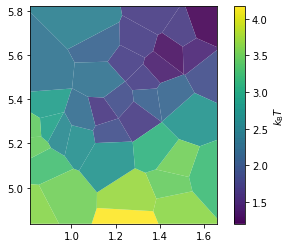

In [13]:
a.mapper.mpl.plot(maps, feature='potential', unit='std')

# Locating the data

## Input data files are not dispatched

The above diagram calls for a long explanation but, first of all, the most important point here is that scripts and executables only are dispatched, and the **input data are NOT dispatched** onto the worker side.

This means that the user has to prepare the data on both the submit and worker sides.
This includes SPT data files and ROI files.

Unless set otherwise, the pipeline seeks the input data files at the same paths on both sides, which is not trivial.
The recommended approach consists of locating the data either from the filesystem root (/) or home/user directory.
The home/user directory path is automatically adjusted from a filesystem to the other.

## Designating side-dependent data locations

A standard setup consists of having the data stored in a (*e.g.* cookiecutter) directory structure, say at root directory *~/Projects/my-project*, on the computer that runs Jupyter, while on the cluster file system the *my-project* subdirectory is available in the personal scratch space.

If the personal scratch space can be found on the cluster reading an environment variable, say *$MYSCRATCH*, and this environment variable is not available on the local computer, one can set the working directory `wd` variable defined at the beginning of the notebook as:

In [14]:
import os

project_dir = '/'.join((os.environ.get('MYSCRATCH', '~/Projects'), 'my_project'))

wd = '/'.join((project_dir, 'data', 'processed')) # standard cookiecutter data location

In situations similar to the above one, with possibly distinct data locations on the submit and worker hosts,
it is also required to instruct the `env` attribute of the RWAnalyzer so that it can map the local *~/Projects* directory to the remote scratch location, using the `directory_mapping` dictionnary of the `env` attribute.

Keys are local paths (on the submit host), values are remote paths (on the worker host).

For scratch locations on the clusters described by some pre-defined environments (*e.g.* Maestro), the path can be programmatically retrieved with:

In [15]:
maestro_username = 'flaurent'

a = RWAnalyzer()

a.env = environments.Maestro

a.env.username = maestro_username # optional if same username on both the submit and worker hosts

a.env.directory_mapping['~/Projects'] = a.env.scratch(maestro_username)

# Designing pipeline stages

## Stage granularity and pipeline-ready iterators

A stage is registered in the RWAnalyzer object using the `pipeline.append_stage` method.
A simple `callable` (Python function) can be passed, like `fresh_start`.

Additional keyword arguments allow to define the granularity of the stage, *i.e.* the level of data representation suitable for distributing the data and running parallel instances of the same stage.

For example, with `granularity='ROI'`, a stage will apply in parallel to each region of interest independently, or more exactly to each *support region* independently.

With `granularity='SPT data'`, a stage will apply in parallel to each SPT data file.

Such control is made possible provided that the stage functions crawl the entire data using the following RWAnalyzer iterators:

* `spt_data` (the attribute itself is iterable),
* `spt_data.as_dataframes`,
* `spt_data.filter_by_source`,
* `roi.as_support_regions` (but **NOT** `roi.as_individual_roi`),
* `time.as_time_segments`.

The predefined stages exposed by the `stages` module are shipped as `PipelineStage` objects that readily contain default granularity settings. For example, the `tessellate_and_infer` stage is set for the ROI granularity, which falls back to SPT data files if no ROI are defined.

Of note, the `roi`-level iterators seamlessly run, independently of whether ROI are defined or not.

## Editing the *tessellate_and_infer* stage

*tessellate\_and\_infer* (or *\_tessellate\_and\_infer* below) can be redefined as a standard function, that we generate here with the following simplified code:

In [16]:
def tessellate_and_infer(map_label=None, sampling_label=None):
    
    def _tessellate_and_infer(self):
        for r in self.roi.as_support_regions():

            # get the data within the ROI as a dataframe
            translocations = r.crop()

            # keep only the molecules that move by more than the localization error
            translocations = r.discard_static_trajectories(translocations)

            # tessellate and run the time window if any
            sampling = self.sampler.sample(translocations)

            # infer the model parameters
            maps = self.mapper.infer(sampling)

            with r.autosaving():
                # wrap the original `sampling` and `maps` objects in node-like objects;
                # this stores the analysis artefacts in the analysis tree for ROI `r`
                sampling = commit_as_analysis(sampling_label, sampling, parent=r)
                maps     = commit_as_analysis(map_label, maps, parent=sampling)
    
    return _tessellate_and_infer

In [17]:
a.pipeline.append_stage(tessellate_and_infer(), granularity='roi')

\[To be continued\]

# Debugging

\[To be continued\]

# Shorter code sample

To make clear what notebook cells are critical in making the presented pipeline run with minimal setup, the definition code is summed up below.

Note that `.run()` should not be called twice in a same Python script or notebook.

In [18]:
import os
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_files('data-examples/*.rpt.txt') # relative paths work alright with LocalHost
a.spt_data.localization_precision = 0.03

a.roi.from_ascii_files(suffix='roi') # => *.rpt-roi.txt

a.tesseller                       = tessellers.Hexagons

a.mapper.from_plugin('stochastic.dv')
a.mapper.diffusivity_prior        = 20
a.mapper.potential_prior          = 1
a.mapper.max_runtime              = 100 # in seconds; 100 seconds is much too short for a proper DV estimation, but convenient for a quick example
a.mapper.verbose                  = False
a.mapper.worker_count             = None if os.name == 'nt' else 4 # Windows OS is not fully supported yet

a.pipeline.append_stage(stages.tessellate_and_infer())

a.env                             = environments.LocalHost
a.env.worker_count                = 5

# this code sample cannot run in the current notebook anyway;
# create a new notebook in the same directory, copy-paste this code cell,
# adjust the filename below so that it points at the new notebook,
# and uncomment the a.run() expression
a.env.script                      = 'Untitled.ipynb'

# a.run()

Of note, relative paths are properly interpreted by the `LocalHost` environment.

Similarly, for dispatching to Maestro:

In [ ]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_files('data-examples/*.rpt.txt') # relative paths on the remote host are interpreted as relative to the home directory
a.spt_data.localization_precision = 0.03

a.roi.from_ascii_files(suffix='roi') # => *.rpt-roi.txt

a.tesseller                       = tessellers.Hexagons

a.mapper.from_plugin('stochastic.dv')
a.mapper.diffusivity_prior        = 20
a.mapper.potential_prior          = 1
a.mapper.max_runtime              = 100 # in seconds; 100 seconds is much too short for a proper DV estimation, but convenient for a quick example
a.mapper.verbose                  = False
a.mapper.worker_count             = 4

a.pipeline.append_stage(stages.tessellate_and_infer())

a.env                             = environments.Maestro
a.env.worker_count                = 50

# this code sample cannot run in the current notebook anyway;
# create a new notebook in the same directory, copy-paste this code cell,
# adjust the filename below so that it points at the new notebook,
# and uncomment the a.run() expression
a.env.script                      = 'Untitled1.ipynb'

## data preparation ##
a.pipeline.early_setup() # this logs in and sets `submit_side` and `worker_side` in the `env` attribute
if a.env.submit_side:
    # transfer local file tutorial.py into the remote home directory
    a.env.ssh.put('tutorial.py')
    # remotely run the raw data download procedure
    out, err = a.env.exec_inline_python('from tutorial import *; download_RWAnalyzer_tour_data()')
    # transfer the local files that are not shipped with the raw data
    for f in a.spt_data:
        roi_file = f.roi.filepath
        a.env.ssh.put(roi_file)
######################

# a.run()

In principle, the initial data transfer (`## data preparation ##` code block) is not part of such a pipeline script/notebook, as it has to be done only once for all, whereas the script may be run multiple times on the same data.

Here, as commented in the code, relative paths are interpreted as relative to the home directory on the remote host. The lack of consistency from an environment to another in the interpretation of relative paths makes it preferable to explicitly locate the data, either making the data available at the same location on all the hosts (possibly using links to directories), or checking out environment variables to define host-dependent absolute paths.